<a href="https://colab.research.google.com/github/sean-halpin/chess_website/blob/models_init/models/Chess_Eval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Download

In [9]:
# https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.zst

In [27]:
!pip install zstandard

In [11]:
import requests
import zstandard
import io

lichess = "https://database.lichess.org/standard/"
dbfile = "lichess_db_standard_rated_2013-01.pgn.zst"
url = lichess + dbfile
compressed_file_path = dbfile
output_path = dbfile.replace(".zst","")

# Download the Zstandard compressed file
response = requests.get(url)
if response.status_code == 200:
    with open(compressed_file_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully to {compressed_file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Extract the Zstandard compressed file
with open(compressed_file_path, 'rb') as compressed_file:
    dctx = zstandard.ZstdDecompressor()
    with dctx.stream_reader(compressed_file) as reader:
        with open(output_path, 'wb') as output:
            output.write(reader.read())

print(f"File extracted successfully to {output_path}")


File downloaded successfully to lichess_db_standard_rated_2013-01.pgn.zst
File extracted successfully to lichess_db_standard_rated_2013-01.pgn


# Data Exploration

In [12]:
!ls

lichess_db_standard_rated_2013-01.pgn  lichess_db_standard_rated_2013-01.pgn.zst  sample_data


In [146]:
!cat lichess_db_standard_rated_2013-01.pgn | grep '\[%eval' | wc -l

518


In [14]:
!cat lichess_db_standard_rated_2013-01.pgn | grep '\[%eval' | head -n5

1. e4 { [%eval 0.2] } 1... e6 { [%eval 0.13] } 2. Bc4 { [%eval -0.31] } 2... d5 { [%eval -0.28] } 3. exd5 { [%eval -0.37] } 3... exd5 { [%eval -0.31] } 4. Bb3 { [%eval -0.33] } 4... Nf6 { [%eval -0.35] } 5. d4 { [%eval -0.34] } 5... Be7 { [%eval 0.0] } 6. Nf3 { [%eval 0.0] } 6... O-O { [%eval -0.08] } 7. Bg5 { [%eval -0.19] } 7... h6 { [%eval -0.29] } 8. Bxf6 { [%eval -0.36] } 8... Bxf6 { [%eval -0.37] } 9. O-O { [%eval -0.36] } 9... c6 { [%eval -0.12] } 10. Re1 { [%eval -0.17] } 10... Bf5 { [%eval -0.04] } 11. c4?! { [%eval -0.67] } 11... dxc4 { [%eval -0.5] } 12. Bxc4 { [%eval -0.77] } 12... Nd7?! { [%eval -0.1] } 13. Nc3 { [%eval 0.0] } 13... Nb6 { [%eval 0.0] } 14. b3?! { [%eval -0.76] } 14... Nxc4 { [%eval -0.49] } 15. bxc4 { [%eval -0.65] } 15... Qa5 { [%eval -0.55] } 16. Rc1 { [%eval -0.79] } 16... Rad8 { [%eval -0.78] } 17. d5?? { [%eval -5.41] } 17... Bxc3 { [%eval -5.42] } 18. Re5? { [%eval -7.61] } 18... Bxe5 { [%eval -7.78] } 19. Nxe5 { [%eval -7.72] } 19... cxd5 { [%eval -

In [65]:
!cat lichess_db_standard_rated_2013-01.pgn | grep '\[%eval' > lichess_db_standard_rated_2013-01.pgn.eval

In [145]:
!pip install python-chess

# Data Visualisation

In [ ]:
import chess.pgn
import re

pgn_text = """
1. e4 { [%eval 0.2] [%eval 0.2] } 1... e6 { [%eval 0.13] } 2. Bc4 { [%eval -0.31] } 2... d5 { [%eval -0.28] } 3. exd5 { [%eval -0.37] } 3... exd5 { [%eval -0.31] } 4. Bb3 { [%eval -0.33] } 4... Nf6 { [%eval -0.35] } 5. d4 { [%eval -0.34] } 5... Be7 { [%eval 0.0] } 6. Nf3 { [%eval 0.0] } 6... O-O { [%eval -0.08] } 7. Bg5 { [%eval -0.19] } 7... h6 { [%eval -0.29] } 8. Bxf6 { [%eval -0.36] } 8... Bxf6 { [%eval -0.37] } 9. O-O { [%eval -0.36] } 9... c6 { [%eval -0.12] } 10. Re1 { [%eval -0.17] } 10... Bf5 { [%eval -0.04] } 11. c4?! { [%eval -0.67] } 11... dxc4 { [%eval -0.5] } 12. Bxc4 { [%eval -0.77] } 12... Nd7?! { [%eval -0.1] } 13. Nc3 { [%eval 0.0] } 13... Nb6 { [%eval 0.0] } 14. b3?! { [%eval -0.76] } 14... Nxc4 { [%eval -0.49] } 15. bxc4 { [%eval -0.65] } 15... Qa5 { [%eval -0.55] } 16. Rc1 { [%eval -0.79] } 16... Rad8 { [%eval -0.78] } 17. d5?? { [%eval -5.41] } 17... Bxc3 { [%eval -5.42] } 18. Re5? { [%eval -7.61] } 18... Bxe5 { [%eval -7.78] } 19. Nxe5 { [%eval -7.72] } 19... cxd5 { [%eval -7.81] } 20. Qe1? { [%eval -9.29] } 20... Be6?? { [%eval 3.71] } 21. Rd1?? { [%eval -12.34] } 21... dxc4 { [%eval -12.71] } 22. Rxd8?! { [%eval #-1] } 22... Rxd8?! { [%eval -13.06] } 23. Qc3?! { [%eval #-2] } 23... Qxc3?! { [%eval #-4] } 24. g3 { [%eval #-3] } 24... Rd1+?! { [%eval #-4] } 25. Kg2 { [%eval #-4] } 25... Qe1?! { [%eval #-4] } 26. Kf3 { [%eval #-3] } 26... Qxe5 { [%eval #-2] } 27. Kg2 { [%eval #-2] } 27... Bd5+?! { [%eval #-2] } 28. Kh3 { [%eval #-1] } 28... Qh5# 0-1
"""

game = chess.pgn.read_game(io.StringIO(pgn_text))

board = game.board()
for node in list(game.mainline()):
    print()
    print(node.move)
    # print(node)
    print(node.comment)
    pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
    match = re.search(pattern, node.comment)
    if match:
        print((match.group(1) if match.group(1) is not None else ""), match.group(2))
    else:
        print("No '%eval' found in the text.")
    board.push(node.move)
    print(board)
    checkMate = board.is_checkmate()
    print("Checkmate?", checkMate)
    i=0
    for square in chess.SQUARES:
      piece = board.piece_at(square)
      print(f"Square {chess.square_name(square)}: {piece}: {piece.piece_type if piece is not None else 0}")


In [134]:
import pandas as pd
rows_data = []
columns = []
for square in chess.SQUARES:
  piece = board.piece_at(square)
  columns.append(chess.square_name(square))
columns.append("eval")
columns.append("check_in")

with open('lichess_db_standard_rated_2013-01.pgn.eval', 'r') as file:
    for pgn_text in file:
      # print(pgn_text)
      game = chess.pgn.read_game(io.StringIO(pgn_text))
      board = game.board()
      for node in list(game.mainline()):
          row_data = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
          pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
          match = re.search(pattern, node.comment)
          if match:
            if match.group(1) is None:
              eval = f"{match.group(2)}"
              check_in = 0 #Integer.MAX_VALUE if board.piece_at(square).color else Integer.MIN_VALUE
            else:
              eval = 0
              check_in = f"{match.group(2)}"
          row_data.append(eval)
          row_data.append(check_in)
          rows_data.append(row_data)
          # move next
          board.push(node.move)

df = pd.DataFrame(rows_data, columns=columns)

In [135]:
df

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,a8,b8,c8,d8,e8,f8,g8,h8,eval,check_in
0,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.2,0
1,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.13,0
2,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,-0.31,0
3,4,2,3,5,6,0,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,-0.28,0
4,4,2,3,5,6,0,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,-0.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34471,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-17.6,0
34472,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-6.72,0
34473,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-11
34474,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-110.16,0


In [136]:
df.dtypes

a1           int64
b1           int64
c1           int64
d1           int64
e1           int64
             ...  
f8           int64
g8           int64
h8           int64
eval        object
check_in    object
Length: 66, dtype: object

In [138]:
df['eval'] = df['eval'].astype(float)
df['check_in'] = df['check_in'].astype(float)

# Define Model

In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3_eval = nn.Linear(32, 1)  # Output for 'eval'
        self.fc3_check_in = nn.Linear(32, 1)  # Output for 'check_in'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        eval_output = self.fc3_eval(x)
        check_in_output = self.fc3_check_in(x)
        return eval_output, check_in_output


In [141]:

# Prepare the data
X = df.drop(columns=['eval', 'check_in']).values
y = df[['eval', 'check_in']].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the model
input_dim = X_train.shape[1]
model = Net(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    eval_output, check_in_output = model(X_train_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_train_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column

    # Compute the loss for 'check_in' output
    check_in_loss = criterion(check_in_output, y_train_tensor[:, 1].view(-1, 1))  # Assuming 'check_in' is the second column

    # Combine the losses (e.g., by summing)
    loss = eval_loss + check_in_loss

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


# Evaluate the model
model.eval()
with torch.no_grad():
    eval_output, check_in_output = model(X_test_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_test_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column

    # Compute the loss for 'check_in' output
    check_in_loss = criterion(check_in_output, y_test_tensor[:, 1].view(-1, 1))  # Assuming 'check_in' is the second column

    # Combine the losses (e.g., by summing)
    test_loss = eval_loss + check_in_loss

    print(f'Test Loss: {test_loss.item()}')


Epoch 1/100, Loss: 128.0177459716797
Epoch 11/100, Loss: 127.66651916503906
Epoch 21/100, Loss: 127.10000610351562
Epoch 31/100, Loss: 126.03297424316406
Epoch 41/100, Loss: 124.21785736083984
Epoch 51/100, Loss: 121.6502456665039
Epoch 61/100, Loss: 118.41768646240234
Epoch 71/100, Loss: 114.55030822753906
Epoch 81/100, Loss: 110.1383056640625
Epoch 91/100, Loss: 105.7192153930664
Test Loss: 104.98641967773438


# Play Chess

********************************* 



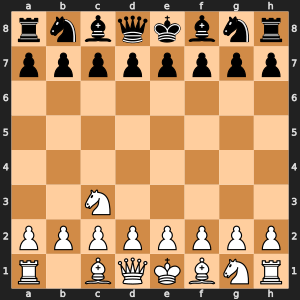

********************************* 



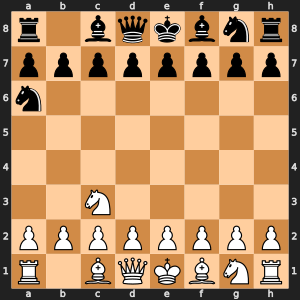

********************************* 



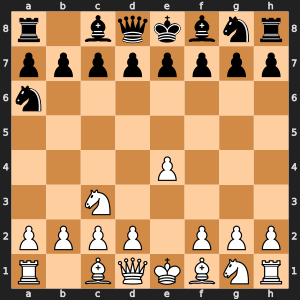

********************************* 



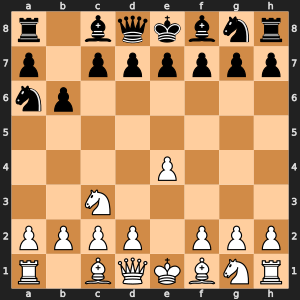

********************************* 



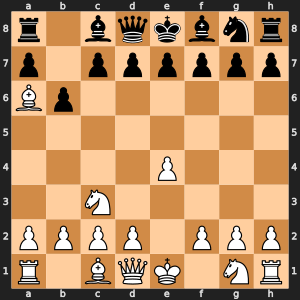

********************************* 



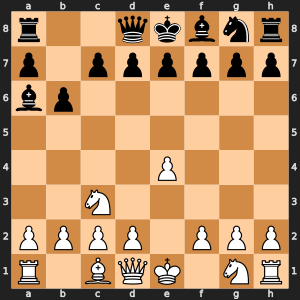

********************************* 



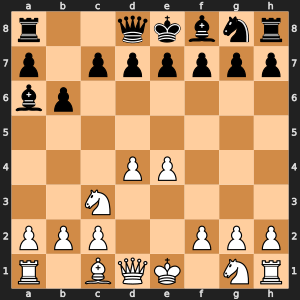

********************************* 



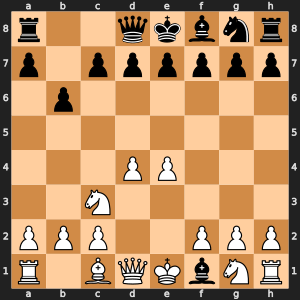

********************************* 



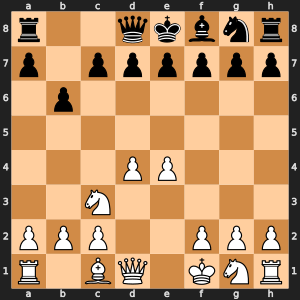

********************************* 



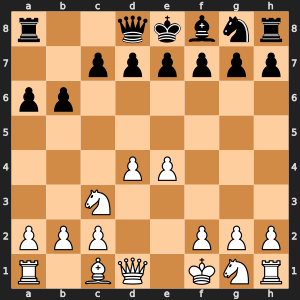

********************************* 



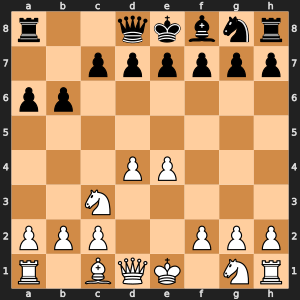

********************************* 



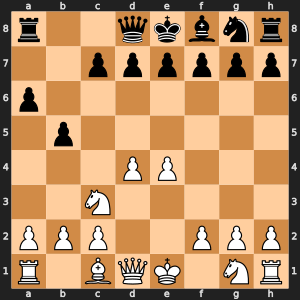

********************************* 



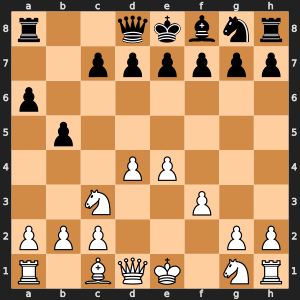

********************************* 



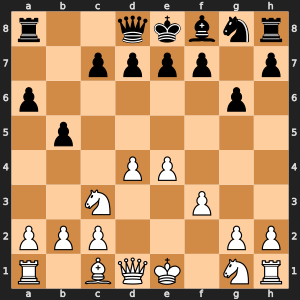

********************************* 



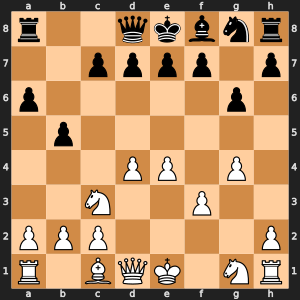

********************************* 



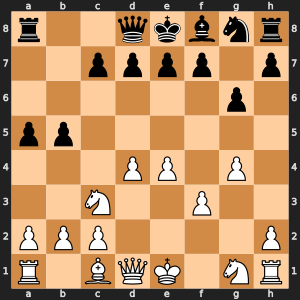

********************************* 



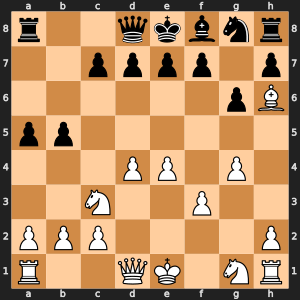

********************************* 



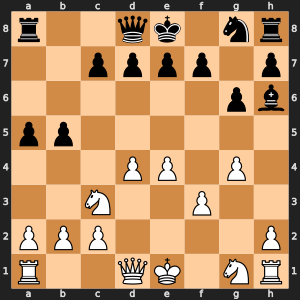

********************************* 



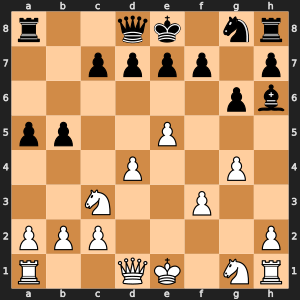

********************************* 



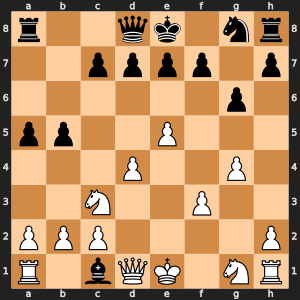

********************************* 



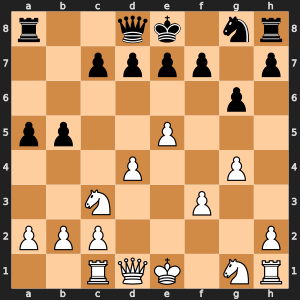

********************************* 



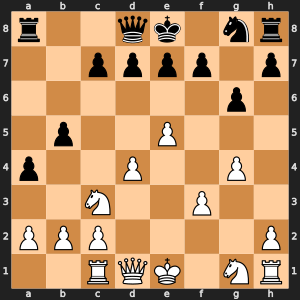

********************************* 



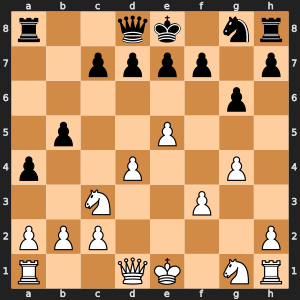

********************************* 



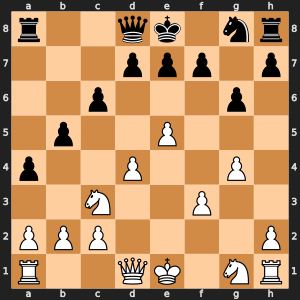

********************************* 



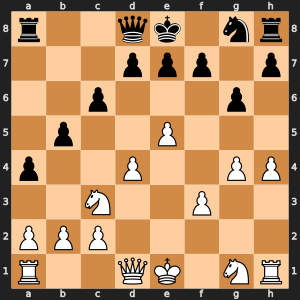

********************************* 



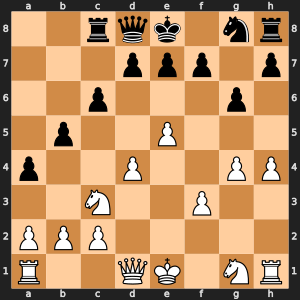

********************************* 



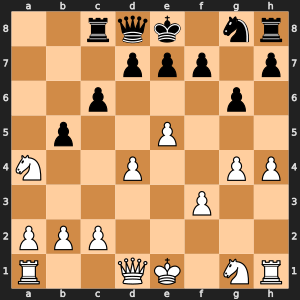

********************************* 



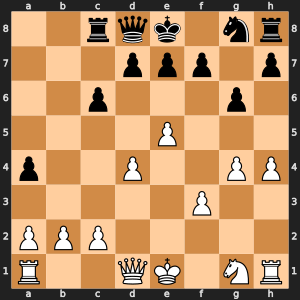

********************************* 



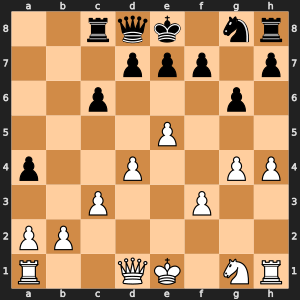

********************************* 



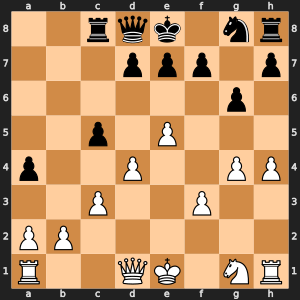

********************************* 



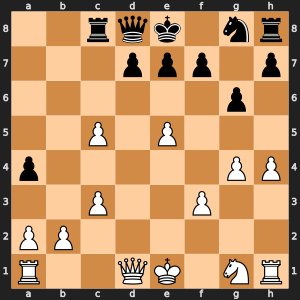

********************************* 



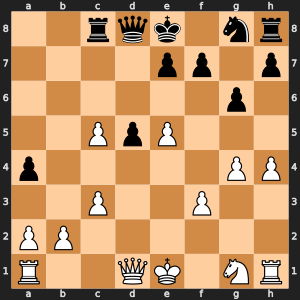

********************************* 



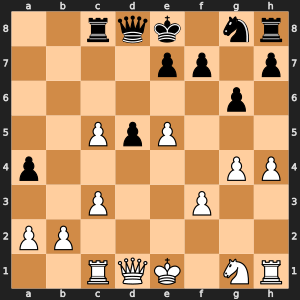

********************************* 



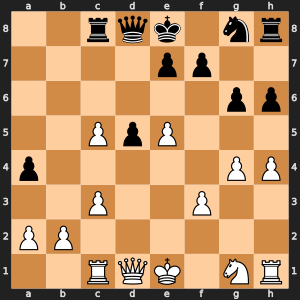

********************************* 



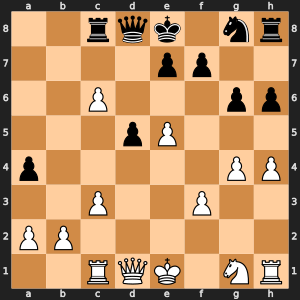

********************************* 



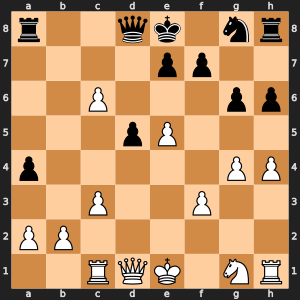

********************************* 



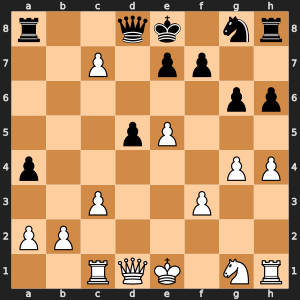

********************************* 



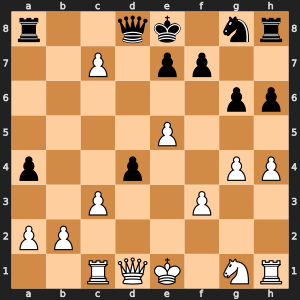

********************************* 



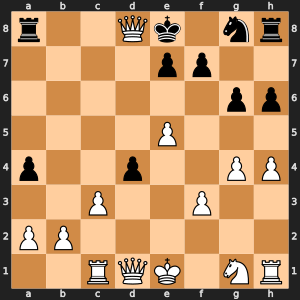

********************************* 



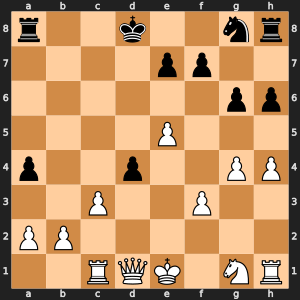

********************************* 



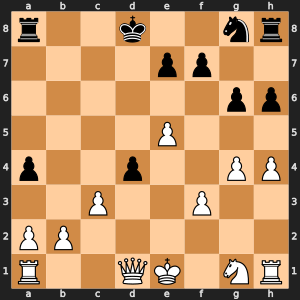

********************************* 



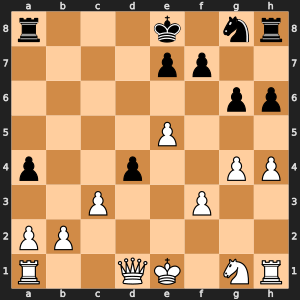

********************************* 



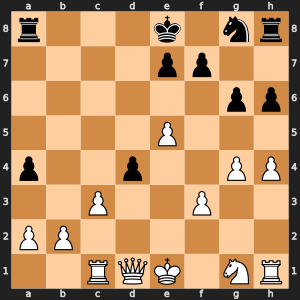

********************************* 



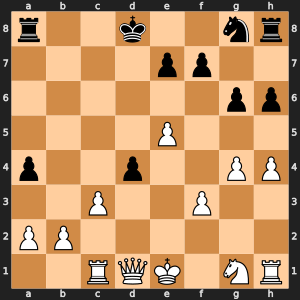

********************************* 



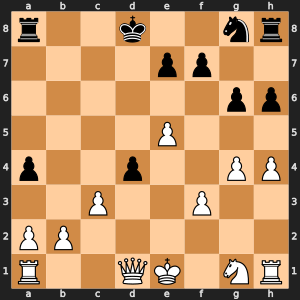

********************************* 



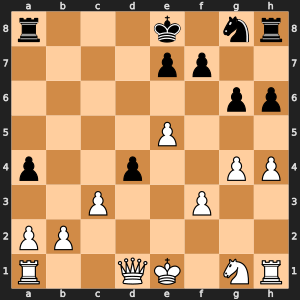

********************************* 



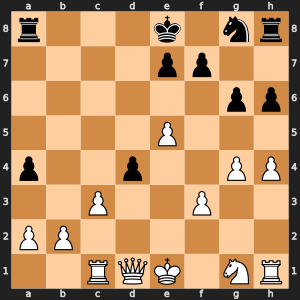

********************************* 



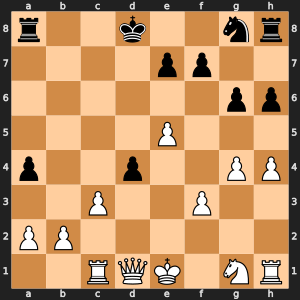

********************************* 



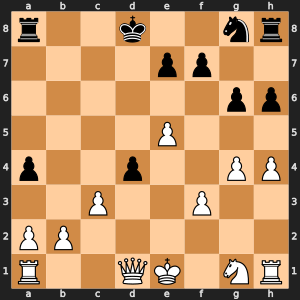

********************************* 



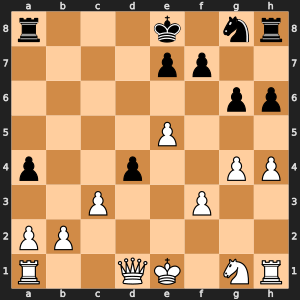

********************************* 



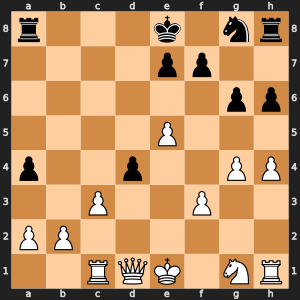

********************************* 



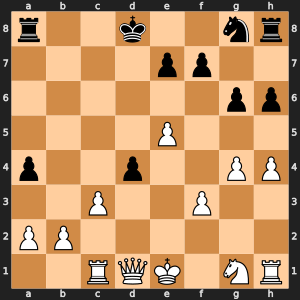

********************************* 



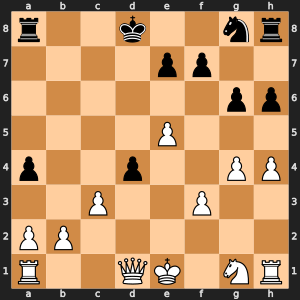

********************************* 



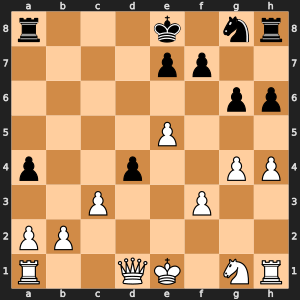

********************************* 



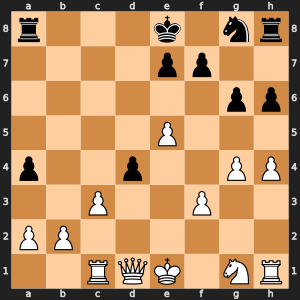

********************************* 



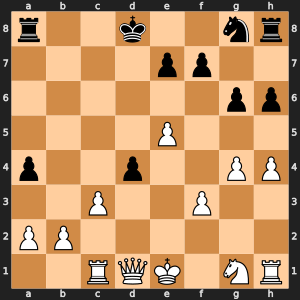

Game Over
Result:  1/2-1/2


In [175]:
import chess
import chess.svg
import torch
from IPython.display import SVG, display

# Define a function to convert the board state into a format suitable for input to the neural network
def preprocess_board_state(board):
    board_state = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
    return torch.tensor(board_state, dtype=torch.float32)

# Define a function to generate legal moves for the current player
def generate_legal_moves(board):
    legal_moves = []
    for move in board.legal_moves:
        legal_moves.append(move)
    return legal_moves

# Evaluate each legal move using the neural network model and select the move with the highest evaluation
def select_best_move(board, legal_moves, model):
    whitePlays = board.turn
    best_move = None
    best_eval = float('-inf') if board.turn else float('inf')  # Initialize best evaluation based on player's perspective

    for move in legal_moves:
        board.push(move)
        board_state = preprocess_board_state(board)
        eval_output, _ = model(board_state)

        # Assuming 'eval_output' contains the evaluation for the current player's perspective
        eval_value = eval_output.item()
        # print(eval_value)

        if whitePlays:  # Maximizing player
            # print(eval_value > best_eval)
            if eval_value > best_eval:
                # print('max')
                best_eval = eval_value
                best_move = move
        else:  # Minimizing player
            # print(eval_value < best_eval)
            if eval_value < best_eval:
                # print('min')
                best_eval = eval_value
                best_move = move

        board.pop()

    return best_move

# Play a game of chess using the model
def play_game(model):
    board = chess.Board()
    while not board.is_game_over():
        if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
            print("Game Over")
            print("Result: ", board.result())
            return

        legal_moves = generate_legal_moves(board)
        if len(legal_moves) == 0:
            print("Game Over - No legal moves left")
            print("Result: ", board.result())
            return

        best_move = select_best_move(board, legal_moves, model)
        board.push(best_move)
        print("*********************************", "\n")
        display(SVG(chess.svg.board(board,size=300)))

    # Print the final result of the game
    print("Game Over")
    print("Result: ", board.result())

# Example usage:
# Assuming 'model' is your trained neural network model
play_game(model)
